In [1]:
import numpy as np 
from numpy.linalg import qr, svd
from scipy.linalg import hadamard, subspace_angles

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.colors as colors

import imageio
import datetime

from kernel_sca import *
from utils import *

import wanb


In [2]:
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy')
d = 3

X, _ = pre_processing(X_init, center=False, soft_normalize='max')
K, N, T = X.shape
A = jnp.swapaxes(pre_processing(X_init,soft_normalize='max')[0], 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

K_A_X = K_X_Y_identity(A, X)                                    #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [3]:

def single_pair_loss(alpha_H, K_A_X, id_1, id_2, operator = 'minus'):
    K_A_X_i = K_A_X[:,id_1,:]
    K_X_A_i = K_A_X[:,id_2,:].T
                  
    Q = jnp.einsum('kd,kt,tj,jm->dm', alpha_H, K_A_X_i, K_X_A_i, alpha_H)    #(KT,D).T @ (KT,T) and (T,KT) @ (KT,D) --> (D,T) @ (T,D) --> (D,D)
    QQ_product = Q @ Q

    if operator == 'minus':
        return jnp.trace(Q)**2 - jnp.trace(QQ_product)
    
    elif operator == 'plus':
        return jnp.trace(Q)**2 + jnp.trace(QQ_product)
 

def loss(alpha_tilde, P, S, K_A_X, X, d, key, normalized = False):  
    K, N, T = X.shape
    
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR


    alpha_reshaped = alpha.reshape(K,T,d)                           #(K, T, D)
    mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)        #(1, T, D)
    alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                #(K*T,D)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(alpha_H, K_A_X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    if normalized == False:
        S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
        return -S
    else: 
        batched_normalizer = vmap(single_pair_loss, in_axes=(None, None, 0, 0, None))(alpha_H, K_A_X, index_pairs[:, 0], index_pairs[:, 1], 'plus')
        return jnp.sum(batched_loss) / jnp.sum(batched_normalizer)

def update(alpha_tilde, P, S, K_A_X, X, d, optimizer, opt_state, key):
    grad_loss = grad(loss)(alpha_tilde, P, S, K_A_X, X, d, key)
  
    updates, opt_state_updated = optimizer.update(grad_loss, opt_state, alpha_tilde)
    alpha_tilde_updated = optax.apply_updates(alpha_tilde, updates)
    return alpha_tilde_updated, opt_state_updated

def optimize(P, S, K_A_X, X, iterations=10000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    alpha_tilde = random.normal(key, (K*T, d))
    
    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(alpha_tilde)

    ls_loss = []
    ls_S_ratio = []
    
    for i in range(iterations):
        alpha_tilde, opt_state = update(alpha_tilde, P, S, K_A_X, X, d, optimizer, opt_state, keys[i])        

        loss_ = loss(alpha_tilde, P, S, K_A_X, X, d, keys[i])
        S_ratio = loss(alpha_tilde, P, S, K_A_X, X, d, keys[i], normalized = True)

        wandb.log({"loss_": loss_, "S_ratio": S_ratio})

        ls_loss.append(loss_)
        ls_S_ratio.append(S_ratio)
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss_}, S_ratio: {S_ratio}")

    return alpha_tilde, ls_loss, ls_S_ratio

wandb.init(project="SCA-project-kernel", name="test", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, iterations= 500, learning_rate= 0.01 )
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 7.219658436952159e-05, S_ratio: 0.21604135632514954
Iteration 10, S: 0.0002689137472771108, S_ratio: 0.34212180972099304
Iteration 20, S: 0.00033361115492880344, S_ratio: 0.30583617091178894
Iteration 30, S: 0.0010640104301273823, S_ratio: 0.3455747067928314
Iteration 40, S: 0.002585682785138488, S_ratio: 0.30895236134529114
Iteration 50, S: 0.007294268812984228, S_ratio: 0.2704195976257324
Iteration 60, S: 0.03493165969848633, S_ratio: 0.24347582459449768
Iteration 70, S: 0.1285497397184372, S_ratio: 0.2503337264060974
Iteration 80, S: 0.7035432457923889, S_ratio: 0.23294824361801147
Iteration 90, S: 2.4771931171417236, S_ratio: 0.24233734607696533
Iteration 100, S: 7.273609161376953, S_ratio: 0.263491153717041
Iteration 110, S: 21.632286071777344, S_ratio: 0.26743197441101074
Iteration 120, S: 29.58741569519043, S_ratio: 0.2621648907661438
Iteration 130, S: 52.24810028076172, S_ratio: 0.24890537559986115
Iteration 140, S: 83.55745697021484, S_ratio: 0.2527735233306885

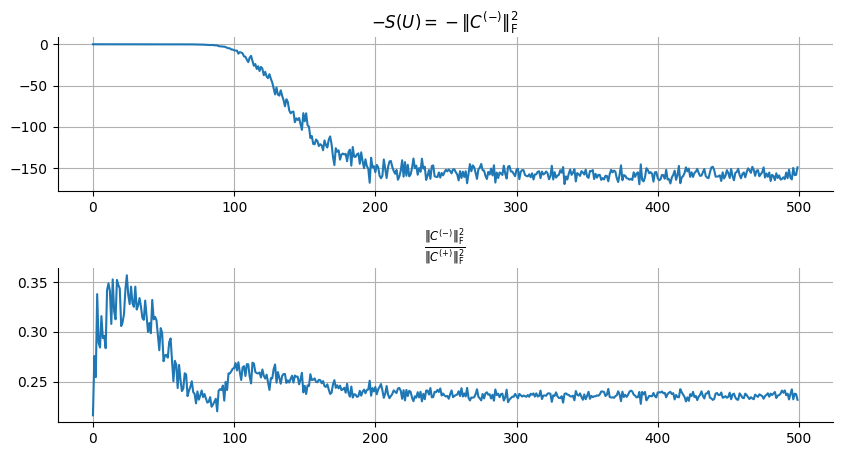

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

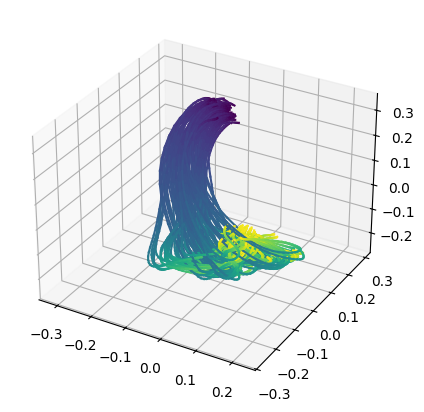

In [12]:

alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
#alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_3D(projection)

In [41]:
U = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/optimized_U_linear_SCA/U_churchland_0.001_10000_3d.npy')
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, pre_processing(X_init, soft_normalize='max')[0])

Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
Q_projection, _ = qr(projection.swapaxes(1,2).reshape(-1,d))
np.rad2deg(subspace_angles(Q_Y, Q_projection))[-1]


80.07225

In [8]:
fig = go.Figure()
num_time_points = projection.shape[-1]
indices_to_plot = np.arange(0,projection.shape[0],1)

for i in indices_to_plot:
    x = projection[i, 0, :]
    y = projection[i, 1, :]
    z = projection[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))
fig.show()
